In [324]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
import matplotlib.colors as colors
import matplotlib.cm as cmx
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC 
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

from Notebook_helpers import load_data
from Notebook_helpers.modeling_helpers import *

%matplotlib inline

## Read in the data

In [335]:
df, train, val, test = load_data.load_coral_data(complete=True, CV=False, convert_to_categorical=True)

## Logistic Regression

#### Data Prep

In [336]:
# isolate the predictors and labels for both the training and test set
train_X = train.iloc[:, 14:34]
train_y = train['Regime']

val_X = val.iloc[:, 14:34]
val_y = val['Regime']

pred_names = df.iloc[:, 14:34].columns

##### Standardize the data

In [337]:
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(train_X.values)

# Apply transform to both the training set and the test set.
train_X = scaler.transform(train_X.values)
val_X = scaler.transform(val_X.values)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### Multiclass logistic regression model (one vs. rest)

##### Fit the model & make predictions

In [5]:
clf = LogisticRegression(solver='liblinear', multi_class='ovr')
clf.fit(train_X, train_y)
#clf = LogisticRegression(random_state=0, solver='saga', multi_class='multinomial').fit(train_X, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [6]:
# make predictions
val_pred = clf.predict(val_X)

##### Evaluate performance

Misclassified samples: 37
Classification Report:
             precision    recall  f1-score   support

          1       0.62      0.69      0.65        26
          2       0.78      0.75      0.76        28
          3       0.52      0.60      0.56        25
          5       0.60      0.43      0.50        21

avg / total       0.63      0.63      0.63       100



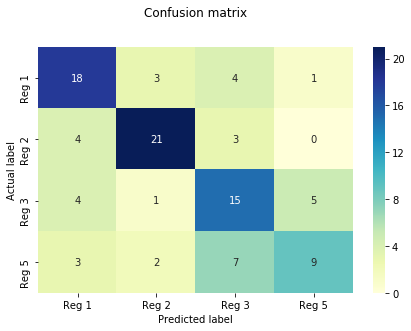

In [7]:
evaluate_performance(val_y, val_pred)

##### Examining variable importance
Since this is no longer a focus for the project, I'm not doing this for the other models. Just keeping this here in case we want to revisit it for the final project writeup.

In [8]:
# create a data frame with the coefficients for all the multiclass logit coefficients
coef_ovr = pd.DataFrame(clf.coef_, index=clf.classes_, columns=pred_names)

In [9]:
# sort predictors by the magnitude of their coefficients for regime 1
np.abs(coef_ovr.iloc[[0,]]).sort_values(by=1, axis=1, ascending=False)

,Effluent,Fishing_NonComm_Shore_Line,SST_STD,Depth,SST_CLIM_M,Fishing_NonComm_Boat_Total,Fishing_NonComm_Shore_Spear,Invasive_Algae,PAR_CLIM_M,Fishing_NonComm_Shore_Net,CHL_CLIM_M,Complexity,Habitat_Modification,WAV_ANOM_F,Sedimentation,Fishing_Comm_Total,CHL_ANOM_F,WAV_CLIM_M,New_Development,PAR_STD
1,2.639081,0.778184,0.646784,0.586206,0.521871,0.51951,0.388728,0.343639,0.294381,0.237793,0.221354,0.139958,0.135203,0.070958,0.061339,0.053058,0.032948,0.02542,0.018377,0.008124


In [10]:
# for regime 2
np.abs(coef_ovr.iloc[[1,]]).sort_values(by=2, axis=1, ascending=False)

,SST_STD,Effluent,Fishing_NonComm_Shore_Spear,WAV_ANOM_F,Complexity,CHL_CLIM_M,PAR_CLIM_M,Fishing_NonComm_Shore_Line,New_Development,WAV_CLIM_M,Fishing_NonComm_Boat_Total,Fishing_Comm_Total,SST_CLIM_M,Invasive_Algae,Habitat_Modification,PAR_STD,Depth,CHL_ANOM_F,Sedimentation,Fishing_NonComm_Shore_Net
2,0.711371,0.517009,0.418174,0.392961,0.378102,0.377502,0.333317,0.319895,0.299668,0.273372,0.272335,0.25337,0.239247,0.22945,0.218788,0.089631,0.08639,0.068502,0.025963,0.016966


In [11]:
# for regime 3
np.abs(coef_ovr.iloc[[2,]]).sort_values(by=3, axis=1, ascending=False)

,SST_STD,CHL_ANOM_F,Fishing_NonComm_Shore_Spear,Fishing_Comm_Total,WAV_CLIM_M,PAR_STD,Fishing_NonComm_Shore_Net,Fishing_NonComm_Shore_Line,CHL_CLIM_M,PAR_CLIM_M,Effluent,New_Development,SST_CLIM_M,Fishing_NonComm_Boat_Total,Habitat_Modification,Complexity,Invasive_Algae,WAV_ANOM_F,Sedimentation,Depth
3,0.953853,0.626184,0.588329,0.545212,0.486791,0.479164,0.3772,0.364994,0.361789,0.349736,0.335244,0.328058,0.291198,0.252243,0.236226,0.218227,0.17796,0.168712,0.016493,0.003376


In [12]:
# for regime 5
np.abs(coef_ovr.iloc[[3,]]).sort_values(by=5, axis=1, ascending=False)

,WAV_ANOM_F,PAR_STD,WAV_CLIM_M,Fishing_NonComm_Shore_Line,Fishing_Comm_Total,Fishing_NonComm_Shore_Spear,Depth,CHL_CLIM_M,Fishing_NonComm_Boat_Total,Habitat_Modification,Fishing_NonComm_Shore_Net,SST_STD,CHL_ANOM_F,PAR_CLIM_M,Complexity,Invasive_Algae,Effluent,SST_CLIM_M,New_Development,Sedimentation
5,0.918782,0.864808,0.604511,0.603624,0.578518,0.572434,0.540372,0.446496,0.394515,0.390409,0.370604,0.361754,0.356559,0.317852,0.293763,0.150484,0.127832,0.071772,0.069645,0.003165


### Multiclass logistic regression model (multinomial)

##### Fit the model & make predictions

In [13]:
clf_multi = LogisticRegression(solver='newton-cg', multi_class='multinomial')
clf_multi.fit(train_X, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [14]:
# make predictions
val_pred_multi = clf_multi.predict(val_X)

##### Evaluate performance

Misclassified samples: 34
Classification Report:
             precision    recall  f1-score   support

          1       0.62      0.77      0.69        26
          2       0.80      0.71      0.75        28
          3       0.59      0.64      0.62        25
          5       0.62      0.48      0.54        21

avg / total       0.67      0.66      0.66       100



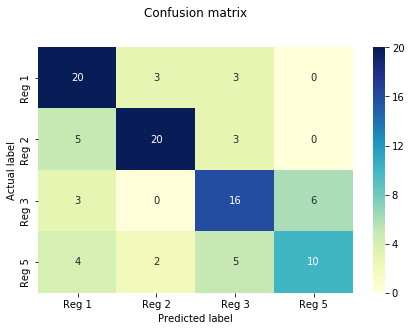

In [20]:
evaluate_performance(val_y, val_pred_multi)

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, zero_one_loss
C = np.logspace(-4, 4, 15)
hyperparameters = dict(C=C)
clf = GridSearchCV(LogisticRegression(solver='newton-cg',
                                      multi_class='multinomial', 
                                      penalty='l2',
                                      random_state=1), 
                   hyperparameters, cv=5, verbose=0, iid=False,
                   scoring=make_scorer(metrics.f1_score, average='micro', greater_is_better=True),
                   return_train_score=True)
best_model = clf.fit(train_X, train_y)

# Best Model is the model picked with the optimal C retrained on the
# entire training data.

print('Best C:', best_model.best_estimator_.get_params()['C'])

Best C: 0.07196856730011514


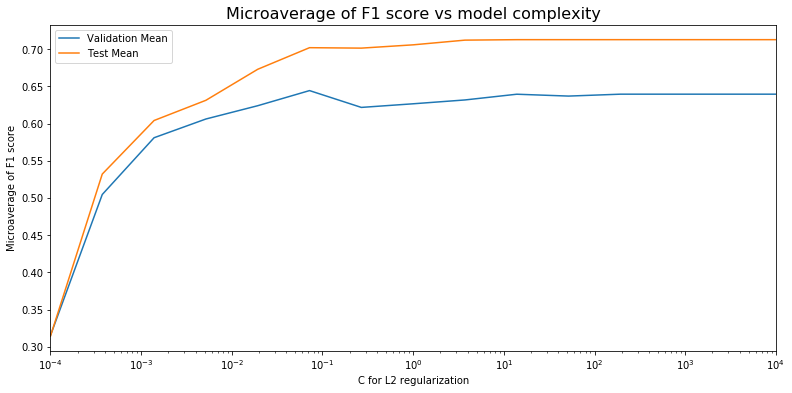

In [17]:
# from scikit-learn, "Demonstration of multi-metric evaluation on cross_val_score and GridSearchCV" 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html
results = clf.cv_results_

plt.figure(figsize=(13, 6))
plt.title("Microaverage of F1 score vs model complexity",
          fontsize=16)

plt.xlabel("C for L2 regularization")
plt.ylabel("Microaverage of F1 score")

ax = plt.gca()
plt.xscale("log")
ax.set_xlim(C[0], C[-1])

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_C'].data, dtype=float)

sample_score_mean = results['mean_test_score']
# sample_score_std = results['std_test_score']

train_score_mean = results['mean_train_score']

# add error bars
plt.errorbar(x = X_axis, y = sample_score_mean, 
             label='Validation Mean', capsize=4, capthick=2)
plt.errorbar(x = X_axis, y = train_score_mean, 
             label='Test Mean', capsize=4, capthick=2)

plt.legend()

plt.grid(False)
plt.show()

## Confusion matrix for Cross Validated Regularization

Misclassified samples: 125
Classification Report:
             precision    recall  f1-score   support

          1       0.76      0.72      0.74       101
          2       0.70      0.72      0.71       107
          3       0.63      0.72      0.67        93
          5       0.65      0.57      0.61        95

avg / total       0.69      0.68      0.68       396



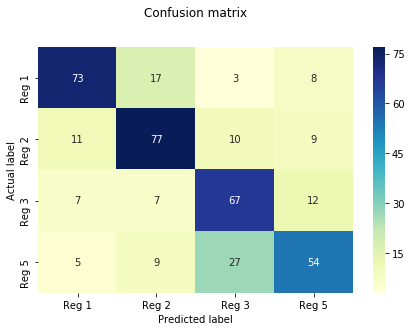

In [22]:
train_pred_multi = best_model.predict(train_X)
evaluate_performance(train_y, train_pred_multi)

## Error Analysis

Goals of this section: 
* Look at the observations where the model was most confident about its predictions
* Look at the misclassified observations where the model was most confident about its predictions? Any trends?

### Create a new df containing each observation's predicted class, predicted probability, true class, and an indicator tracking whether the prediction was correct

In [147]:
# get the probability estimates from our model for every class for every observation
    # softmax function has been used to find the predicted prob. of each class
train_pred_prob = best_model.predict_proba(train_X)

In [149]:
# get the prob. estimate associated with the model's final prediction for each observation
    # getting the max prediction probability for every observation
final_pred_prob = train_pred_prob[np.arange(len(train_pred_prob)), 
                                  np.argmax(train_pred_prob, axis=1)]

In [150]:
# create df with each observation's predicted class, predicted probability, & true class 
error_analysis_df = pd.DataFrame({'pred_class': train_pred_multi, 
                                  'label': train_y, 
                                  'pred_prob': final_pred_prob})

In [158]:
# create a new column in the df tracking if the prediction was correct
error_analysis_df['correct'] = 0
error_analysis_df.loc[error_analysis_df['pred_class'] == error_analysis_df['label'], 'correct'] = 1

In [164]:
error_analysis_df.head()

,pred_class,label,pred_prob,correct
0,1,3,0.371956,0
1,3,5,0.542155,0
2,1,1,0.931944,1
3,5,5,0.407940,1
4,3,3,0.760041,1


### Analyze the distribution of the prediction probabilities
For all observations:

In [151]:
# get summary statistics on the probabilities of the predicted class
error_analysis_df['pred_prob'].describe()

count    396.000000
mean       0.599241
std        0.174684
min        0.277231
25%        0.464556
50%        0.555283
75%        0.747394
max        0.954925
Name: pred_prob, dtype: float64

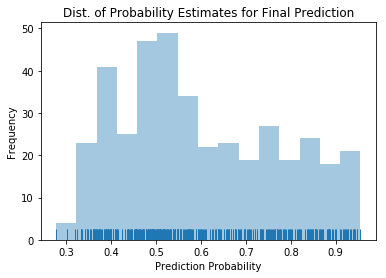

In [229]:
# plot the distribution of the probability estimates for the model's final prediction
sns.distplot(error_analysis_df[('pred_prob')], kde=False, rug=True, bins=15)
plt.title('Dist. of Probability Estimates for Final Prediction')
# Set x-axis label
plt.xlabel('Prediction Probability')
# Set y-axis label
plt.ylabel('Frequency')

plt.show()

Stratified by correct vs. inaccurate classifications:

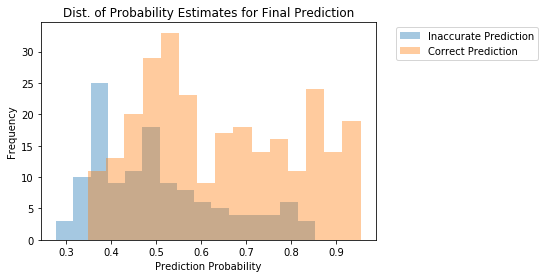

In [227]:
fig, ax = plt.subplots()
# plot distribution of probability estimates stratified by accuracy of the classification
for a in [error_analysis_df[error_analysis_df[('correct')] == 0]['pred_prob'], 
           error_analysis_df[error_analysis_df[('correct')] == 1]['pred_prob']]:
    sns.distplot(a, bins=15, ax=ax, kde=False)

plt.title('Dist. of Probability Estimates for Final Prediction')
# Set x-axis label
plt.xlabel('Prediction Probability')
# Set y-axis label
plt.ylabel('Frequency')

# create legend
leg = plt.legend(labels=['Inaccurate Prediction','Correct Prediction'], 
                 loc = 'upper right')
# Get the bounding box of the original legend
bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
# Change to location of the legend. 
xOffset = 0.5
bb.x0 += xOffset
bb.x1 += xOffset
leg.set_bbox_to_anchor(bb, transform = ax.transAxes)

plt.show()

The stratified histogram above is reassuring as it shows that when a model classified an observation incorrectly, it generally had lower confidence in that prediction as compared to observations that it categorized correctly.

In [ ]:
## ADD THE ADDITIONAL PLOT IN THE ML SLIDES

### Deep dive into the observations where the model was most confident about its predictions
Let's isolate the top 10% of observations that the model was most confident about. This will amount to ~40 observations.

In [589]:
# print the first 5 observations of this group
error_analysis_df.sort_values(by='pred_prob', ascending=False).head()

,pred_class,label,pred_prob,correct
73,1,1,0.954925,1
132,1,1,0.947508,1
119,1,1,0.946939,1
379,1,1,0.942105,1
264,2,2,0.941169,1


In [419]:
# number of observations if we isolate the top 10%
top_10p = round(error_analysis_df.shape[0] * 0.1)
# get the indices of the top 10%
idx = error_analysis_df.sort_values(by='pred_prob', ascending=False)[0:top_10p].index.tolist()

# get these 40 observations and the relevant feature columns
subset = train.iloc[idx, 15:35]

##### Check to see if there were any observations in this group that were misclassified:

In [590]:
error_analysis_df.iloc[idx, ]['correct'].value_counts()

1    40
Name: correct, dtype: int64

All observations in this group were classified correctly.

##### Now let's take a look at what percentage of observations from each class fall within this "top confidence" group:

In [591]:
# create a data frame containing the number of obs. from each class in this subset and the total counts of each class
subset_correct_perc = pd.DataFrame({'correct_counts': error_analysis_df.iloc[idx, ]['label'].value_counts(),
                                    'total_counts': error_analysis_df['label'].value_counts()})
subset_correct_perc['fraction'] = subset_correct_perc['correct_counts'] / subset_correct_perc['total_counts']

subset_correct_perc

,correct_counts,total_counts,fraction
1,20,101,0.198020
2,14,107,0.130841
3,0,93,0.000000
5,6,95,0.063158


It appears that the model was most confident in its predictions for classes 1 and 2. None of the observations categorized as Regime 3 fall into this group and only 6 from Regime 5 fell in this group. 

##### Now let's compare the distribution of features for our "top confidence" group against the distribution of features for our whole training set. Let's do this by overlaying distributions for each feature. 

In [ ]:
# make a list of columns that are floats since we can't make histograms with non-floats
    # note
float_cols = subset.iloc[:, np.r_[0:3, 5:20]].columns

In [667]:
# across all 4 classes (not as useful so commented out)
# fig, axes = plt.subplots(5,4, figsize = (16,18))
# for i, col in enumerate(float_cols):
#     for df in [subset.loc[:,float_cols], train.loc[:, float_cols]]:
#         sns.distplot(df[col], 
#                      bins=np.linspace(min(train.loc[:, col]), max(train.loc[:, col]), 15), 
#                      ax=axes[i // 4, i % 4], kde = False, norm_hist= True)

##### For Regime 1: 
(since more than half of the correctly classified observations in the "high confidence" group were for Regime 1)

In [661]:
# get the indices of the 20 regime 1 observations
sub_r1_idx = error_analysis_df.iloc[idx,]
sub_r1_idx = sub_r1_idx[sub_r1_idx['label'] == 1]
sub_r1_idx = sub_r1_idx.index.tolist()

# get the relevant feature columns for these 20 observations
subset_r1 = train.iloc[sub_r1_idx, 15:35]

# get all the regime 1 observations and the relevant features from train
r1_idx = error_analysis_df[error_analysis_df['label'] == 1].index.tolist()
r1 = train.iloc[r1_idx, 15:35]

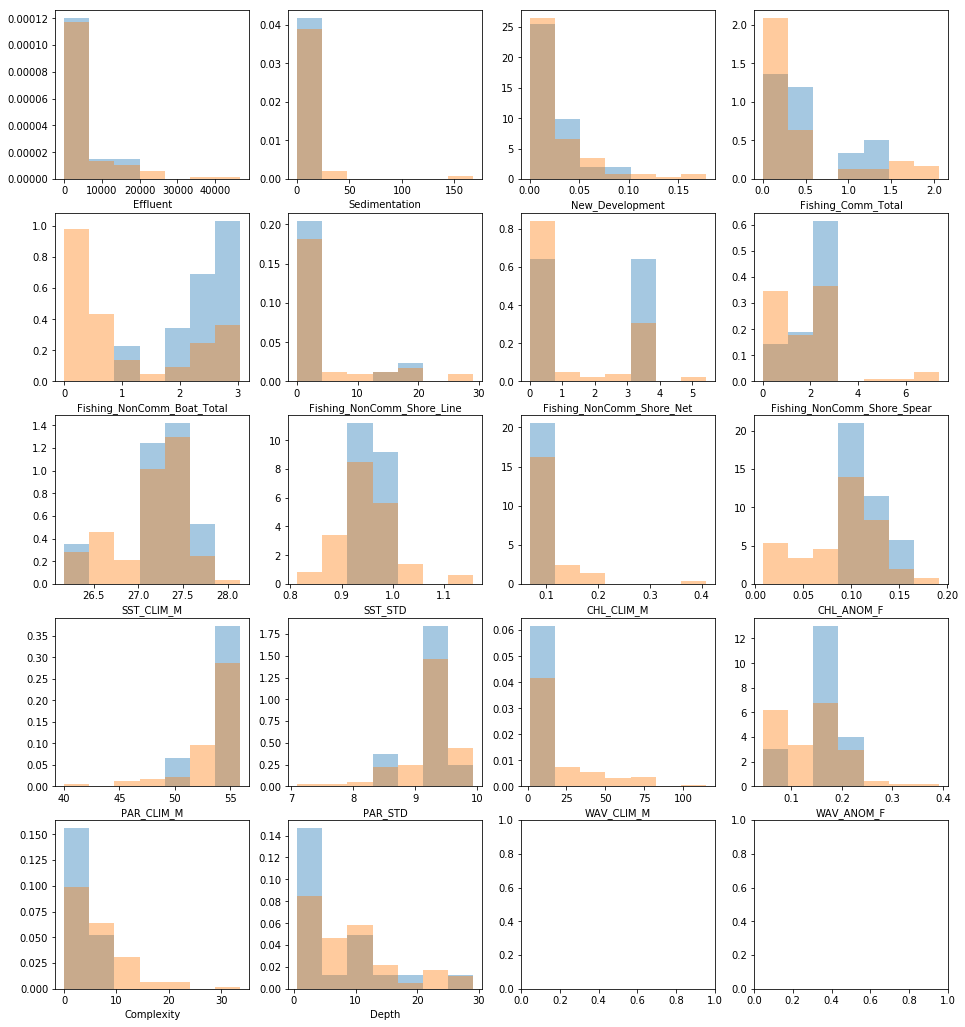

In [666]:
fig, axes = plt.subplots(5,4, figsize = (16,18))
for i, col in enumerate(float_cols):
    for df in [subset_r1.loc[:,float_cols], r1.loc[:, float_cols]]:
        sns.distplot(df[col], 
                     bins=np.linspace(min(r1.loc[:, col]), max(r1.loc[:, col]), 8), 
                     ax=axes[i // 4, i % 4], kde = False, norm_hist= True)

### Deep dive into misclassified observations where the model was most confident about its predictions
Let's isolate the top 10% of misclassified observations that the model was most confident about. This will amount to ~40 observations.

In [608]:
# print the observations of this group
misclass_df = error_analysis_df[error_analysis_df['correct'] == 0].sort_values(by='pred_prob', ascending=False)
misclass_df[0 : top_10p]

,pred_class,label,pred_prob,correct
340,5,1,0.853232,0
350,2,1,0.838038,0
277,1,2,0.837539,0
365,2,3,0.801964,0
344,1,2,0.797320,0
76,2,3,0.793977,0
332,1,3,0.787808,0
120,1,3,0.783965,0
6,2,1,0.781871,0
389,3,5,0.776127,0


In [629]:
# number of observations if we isolate the top 10%
#top_5p = round(error_analysis_df.shape[0] * 0.05)

In [630]:
# get the indices of the top 10%
mis_idx = misclass_df[0 : top_10p].index.tolist()

# get these 40 observations and the relevant feature columns
mis_subset = train.iloc[mis_idx, 15:35]

Now let's take a look at what percentage of observations from each class fall within this "top confidence" group:

In [632]:
# create a data frame containing the number of obs. from each class in this subset and the total counts of each class
mis_subset_perc = pd.DataFrame({'subset_counts': error_analysis_df.iloc[mis_idx, ]['label'].value_counts(),
                                    'total_counts': error_analysis_df['label'].value_counts()})
mis_subset_perc['fraction'] = mis_subset_perc['subset_counts'] / mis_subset_perc['total_counts']

mis_subset_perc

,subset_counts,total_counts,fraction
1,10,101,0.099010
2,10,107,0.093458
3,9,93,0.096774
5,11,95,0.115789


Looks like the model had high confidence misclassifications for all 4 regimes. 

In [ ]:
fig, axes = plt.subplots(5,4, figsize = (16,18))
for i, col in enumerate(float_cols):
    for df in [mis_subset.loc[:,float_cols], train.loc[:, float_cols]]:
        sns.distplot(df[col], 
                     bins=np.linspace(min(train.loc[:, col]), max(train.loc[:, col]), 15), 
                     ax=axes[i // 4, i % 4], kde = False, norm_hist= True)